# Multilabel News Article Classification

In [33]:
import pandas as pd
import json
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from sentence_transformers import SentenceTransformer, models

### Read in Data

In [34]:
data = pd.read_json('cc_data_and_labels.jsonl', lines=True)
data.head()

,text,id,title,description,date,meaning,category
0,Cyberbit Ltd.\nCyberbit wird von unabhängigem ...,6aba0f3762b987b997afc8d21b2708cf92d56e54f08710...,Cyberbit wird von unabhängigem Forschungsunter...,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,2023-12-12 16:26:22+00:00,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,technology
1,Cyberbit Ltd.\nCyberbit wird von unabhängigem ...,9f948c4b5229a4930ee7a6583e20cfeae10647ed6dfce2...,Cyberbit wird von unabhängigem Forschungsunter...,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,2023-12-12 16:26:14+00:00,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,technology
2,WASHINGTON (AP) — President Joe Biden describe...,203852ceae3fd1d12b47dc1f581d086a964a064dad39bf...,Biden calls Australia ‘an anchor to peace and ...,WASHINGTON (AP) — President Joe Biden describe...,2023-10-27 22:26:07+00:00,WASHINGTON (AP) — President Joe Biden describe...,politics
3,"Un’amicizia sociale, la definirebbe papa Franc...",5248d1ed5a58da7f27266c7ef14c7f07966dee885dab8a...,"Modica, carabinieri e casa Don Puglisi per cre...",A Modica l'amicizia sociale tra l'Arma dei car...,2023-12-12 16:17:01+00:00,A Modica l'amicizia sociale tra l'Arma dei car...,culture
4,"New Delhi, Finance Minister Nirmala Sitharaman...",dc80e51187756385c77ececd68fd16a45b4ff1b212dd5f...,Finance Minister Nirmala Sitharaman meets head...,This is the probably last full review meeting ...,2023-12-30 15:08:18+00:00,This is the probably last full review meeting ...,economy


### Check how much of each category is present


In [35]:
data['category'].value_counts()

category
politics             91336
business             73302
entertainment        55078
cyber                52230
sports               49503
crime                42988
uncategorized        37059
technology           34477
culture              26768
economy              18561
health               13905
advertising           9695
weather               8593
national security     7144
science               2864
Name: count, dtype: int64

### This is a very imbalanced dataset. After doing some research into balancing datasets, I think an appropriate approach is to create a balanced dataframe with 2864 observations of each label. By training on this data, it will result in our model overpredicting the dominant classes.

In [36]:
#Drop duplicate data. 
data = data.drop_duplicates(subset = ['id', 'title'])
data = data.dropna(subset = ['category'])

In [37]:
#Drop articles that were parsed into the df incorrectly (ChatGPT Helped us here)
data = data[~data['text'].astype(str).str.startswith('{')]
print(f' we have {data.shape[0]} unique records to work with after filtering')

 we have 493925 unique records to work with after filtering


### Now we need to embed our data

In [38]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load the LaBSE model
model = SentenceTransformer('sentence-transformers/LaBSE', device='cuda')

# Create embeddings for your text data
texts = data['meaning'].astype(str).tolist()
embeddings = model.encode(texts, show_progress_bar=True, batch_size=64)

# Add embeddings to DataFrame
data['embedding'] = list(embeddings)

Batches: 100%|██████████| 7718/7718 [16:20<00:00,  7.87it/s] 


### We now need to map each category to a number for training. Originally COL Beskow wanted business/economy & health/sciecne separate. After seeing how subjective these labels can be, we settled to allow these to be classified as the same category number

In [318]:
#Map categories to numbers. ChatGPT helped me with this code. 
category_group_map = {
    'politics': 'politics',
    'business': 'business',
    'economy': 'business',
    'entertainment': 'entertainment',
    'cyber': 'cyber',
    'sports': 'sports',
    'crime': 'crime',
    'uncategorized': 'uncategorized',
    'technology': 'technology',
    'culture': 'culture',
    'health': 'health',
    'science': 'health',
    'advertising': 'advertising',
    'weather': 'weather',
    'national security': 'national security',
}



# Apply mapping to normalize categories
data['category_group'] = data['category'].map(category_group_map)
# Drop rows where 'category_group' is 'uncategorized'
data = data[data['category_group'] != 'uncategorized']

# Convert to multilabel format (as lists)
data['categories'] = data['category_group'].apply(lambda x: [x])
data.head()

,text,id,title,description,date,meaning,category,embedding,category_group,categories,preds
0,Cyberbit Ltd.\nCyberbit wird von unabhängigem ...,6aba0f3762b987b997afc8d21b2708cf92d56e54f08710...,Cyberbit wird von unabhängigem Forschungsunter...,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,2023-12-12 16:26:22+00:00,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,technology,"[-0.02115992, -0.040797986, -0.00014715496, 0....",technology,[technology],"[cyber, technology]"
1,Cyberbit Ltd.\nCyberbit wird von unabhängigem ...,9f948c4b5229a4930ee7a6583e20cfeae10647ed6dfce2...,Cyberbit wird von unabhängigem Forschungsunter...,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,2023-12-12 16:26:14+00:00,Cyberbit Ltd. - Boston (ots/PRNewswire) - Cybe...,technology,"[-0.02115992, -0.040797986, -0.00014715496, 0....",technology,[technology],"[cyber, technology]"
2,WASHINGTON (AP) — President Joe Biden describe...,203852ceae3fd1d12b47dc1f581d086a964a064dad39bf...,Biden calls Australia ‘an anchor to peace and ...,WASHINGTON (AP) — President Joe Biden describe...,2023-10-27 22:26:07+00:00,WASHINGTON (AP) — President Joe Biden describe...,politics,"[-0.07052566, -0.02216028, 0.0050470983, 0.018...",politics,[politics],[politics]
3,"Un’amicizia sociale, la definirebbe papa Franc...",5248d1ed5a58da7f27266c7ef14c7f07966dee885dab8a...,"Modica, carabinieri e casa Don Puglisi per cre...",A Modica l'amicizia sociale tra l'Arma dei car...,2023-12-12 16:17:01+00:00,A Modica l'amicizia sociale tra l'Arma dei car...,culture,"[-0.03306774, -0.003254108, -0.03962295, -0.05...",culture,[culture],[culture]
4,"New Delhi, Finance Minister Nirmala Sitharaman...",dc80e51187756385c77ececd68fd16a45b4ff1b212dd5f...,Finance Minister Nirmala Sitharaman meets head...,This is the probably last full review meeting ...,2023-12-30 15:08:18+00:00,This is the probably last full review meeting ...,economy,"[-0.031081716, -0.0593708, -0.018366195, -0.00...",business,[business],"[business, politics]"


In [319]:
from sklearn.preprocessing import MultiLabelBinarizer

all_groups = sorted(data['category_group'].unique())  # unique merged groups
mlb = MultiLabelBinarizer(classes=all_groups)

y = mlb.fit_transform(data['categories'])


### Create a balanced df

In [320]:
import pandas as pd
import numpy as np
from sklearn.utils import resample

# Reattach y to your data so each row has its binary labels
label_df = pd.DataFrame(y, columns=mlb.classes_)
data_multi = pd.concat([data.reset_index(drop=True), label_df], axis=1)

# For each label, sample rows where that label is 1
min_label_count = label_df.sum().min()

balanced_rows = []
for label in mlb.classes_:
    df_label = data_multi[data_multi[label] == 1]
    sampled = resample(
        df_label,
        replace=False,
        n_samples=min_label_count,
        random_state=42
    )
    balanced_rows.append(sampled)

# Combine all sampled rows, drop duplicates
balanced_data = pd.concat(balanced_rows).drop_duplicates(subset='text').reset_index(drop=True)

# Recreate X and y from balanced_data
X = np.stack(balanced_data['embedding'].values)
y_balanced = balanced_data[mlb.classes_].values


In [321]:
# Recreate X and y so we can use the indices
#ChatGPT Helped me split the data
from sklearn.model_selection import train_test_split
import numpy as np

# Recreate X and multilabel y
X = np.stack(balanced_data['embedding'].values)
y = balanced_data[mlb.classes_].values

# Preserve original indices for optional access
original_indices = balanced_data.index.values

# Multilabel-aware splitting (note: stratify doesn't work with multilabel directly)
X_train, X_temp, y_train, y_temp, idx_train, idx_temp = train_test_split(
    X, y, original_indices, test_size=0.3, random_state=24)

X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_temp, y_temp, idx_temp, test_size=0.5, random_state=42)

# Optional: get test DataFrame
test = balanced_data.loc[idx_test].reset_index(drop=True)



### Create our model

In [322]:
#GrokAI Helped create the model
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models, optimizers
from tensorflow.keras.activations import swish

# Number of multilabel classes (e.g. len(mlb.classes_))
num_labels = 12

inputs = layers.Input(shape=(768,), name='input_layer')

# Initial projection
x = layers.Dense(1024, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(inputs)
x = layers.LayerNormalization()(x)
x = layers.Dropout(0.4)(x)

# Residual Block 1
res = layers.Dense(1024, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
res = layers.LayerNormalization()(res)
res = layers.Dropout(0.4)(res)
x = layers.Add()([x, res])  # Residual connection

# Deep residual block stack
for _ in range(4):
    dense = layers.Dense(1024, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
    dense = layers.LayerNormalization()(dense)
    dense = layers.Dropout(0.3)(dense)
    x = layers.Add()([x, dense])

# Wide dense layer block
wide = layers.Concatenate()([
    layers.Dense(256, activation='relu')(x),
    layers.Dense(256, activation='sigmoid')(x),
    layers.Dense(256, activation='tanh')(x)
])
x = layers.Concatenate()([x, wide])  # Final wide layer shape = 1024 + 3*256 = 1792

# Final MLP layers
x = layers.Dense(512, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation=swish, kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)

# 🔄 Multilabel Output Layer
outputs = layers.Dense(num_labels, activation='sigmoid')(x)

# Build and compile the model
model = models.Model(inputs=inputs, outputs=outputs, name="ultra_dense_multilabel_classifier")
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

model.summary()





Model: "ultra_dense_multilabel_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 768)]        0           []                               
                                                                                                  
 dense_86 (Dense)               (None, 1024)         787456      ['input_layer[0][0]']            
                                                                                                  
 layer_normalization_44 (LayerN  (None, 1024)        2048        ['dense_86[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 dropout_58 (Dropout)           (None, 1024)         0           [

In [323]:
#ChatGPT helped me integrate callbacks
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',            # Watch validation loss
    patience=6,                    # Stop after 6 epochs without improvement
    restore_best_weights=True,    # Roll back to the best weights
    verbose=1                      # Print when early stopping happens
)

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs = 100,
    batch_size=64,
    callbacks=[early_stopping],   # 👈 Add this line
    verbose=1
)



Epoch 1/100
683/683 [==============================] - 47s 64ms/step - loss: 0.9493 - binary_accuracy: 0.9137 - val_loss: 0.8098 - val_binary_accuracy: 0.9524
Epoch 2/100
683/683 [==============================] - 43s 63ms/step - loss: 0.8067 - binary_accuracy: 0.9455 - val_loss: 0.7445 - val_binary_accuracy: 0.9557
Epoch 3/100
683/683 [==============================] - 43s 64ms/step - loss: 0.7293 - binary_accuracy: 0.9507 - val_loss: 0.6782 - val_binary_accuracy: 0.9568
Epoch 4/100
683/683 [==============================] - 43s 63ms/step - loss: 0.6541 - binary_accuracy: 0.9531 - val_loss: 0.6083 - val_binary_accuracy: 0.9567
Epoch 5/100
683/683 [==============================] - 43s 64ms/step - loss: 0.5823 - binary_accuracy: 0.9545 - val_loss: 0.5425 - val_binary_accuracy: 0.9570
Epoch 6/100
683/683 [==============================] - 43s 64ms/step - loss: 0.5157 - binary_accuracy: 0.9555 - val_loss: 0.4777 - val_binary_accuracy: 0.9570
Epoch 7/100
683/683 [=========================

### Predict on Test set

In [324]:
y_pred_probs = model.predict(X_test)  # This gives probabilities
import numpy as np

# Assuming y_pred_probs is the predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)

y_pred.shape

293/293 [==============================] - 5s 15ms/step


(9363,)

### Create some visualizations

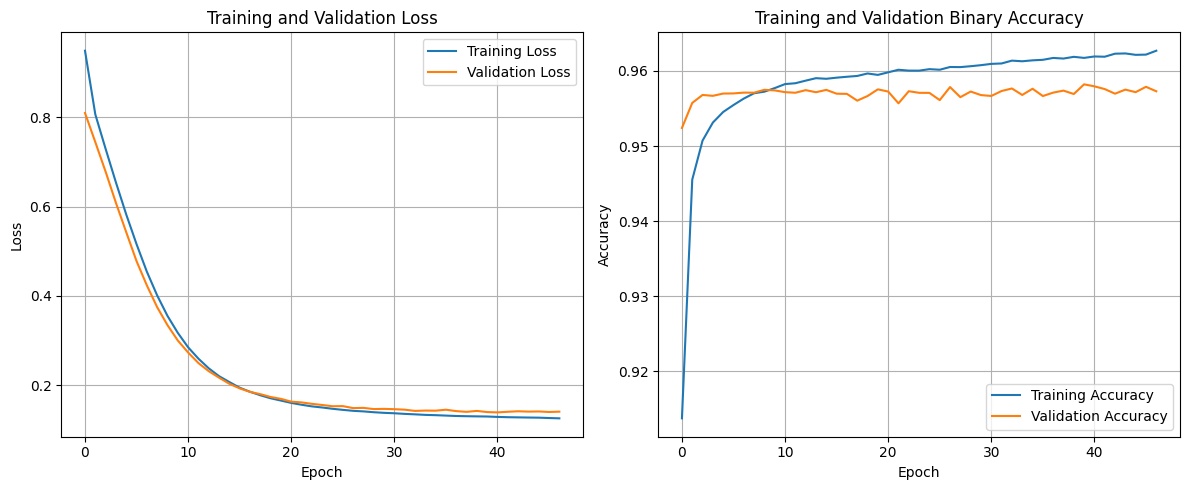

In [325]:
#ChatGPT helped create this viz
# Plot training & validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Binary Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [326]:
import numpy as np

# Convert probabilities to binary predictions using a threshold of 0.5 (GrokAI helped)
threshold = 0.25
y_pred_binary = (y_pred_probs >= threshold).astype(int)

## Lets create some visualizations showcasing our model's performance

In [327]:
#ChatGPT helped me create this report
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_binary, target_names=mlb.classes_, output_dict=True)

# Convert to DataFrame for better visualization
import pandas as pd
report_df = pd.DataFrame(report).transpose()
print(report_df[['precision', 'recall', 'f1-score', 'support']])

                   precision    recall  f1-score  support
advertising         0.678632  0.703901  0.691036    564.0
business            0.707933  0.725369  0.716545    812.0
crime               0.703663  0.747642  0.724986    848.0
culture             0.629371  0.749108  0.684039    841.0
cyber               0.710280  0.729892  0.719953    833.0
entertainment       0.630682  0.649123  0.639769    684.0
health              0.811736  0.791418  0.801448    839.0
national security   0.657534  0.733758  0.693558    785.0
politics            0.639164  0.709402  0.672454    819.0
sports              0.853350  0.836431  0.844806    807.0
technology          0.592050  0.702233  0.642452    806.0
weather             0.872648  0.831724  0.851695    725.0
micro avg           0.702319  0.744099  0.722605   9363.0
macro avg           0.707254  0.742500  0.723562   9363.0
weighted avg        0.707663  0.744099  0.724513   9363.0
samples avg         0.654794  0.744099  0.684200   9363.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


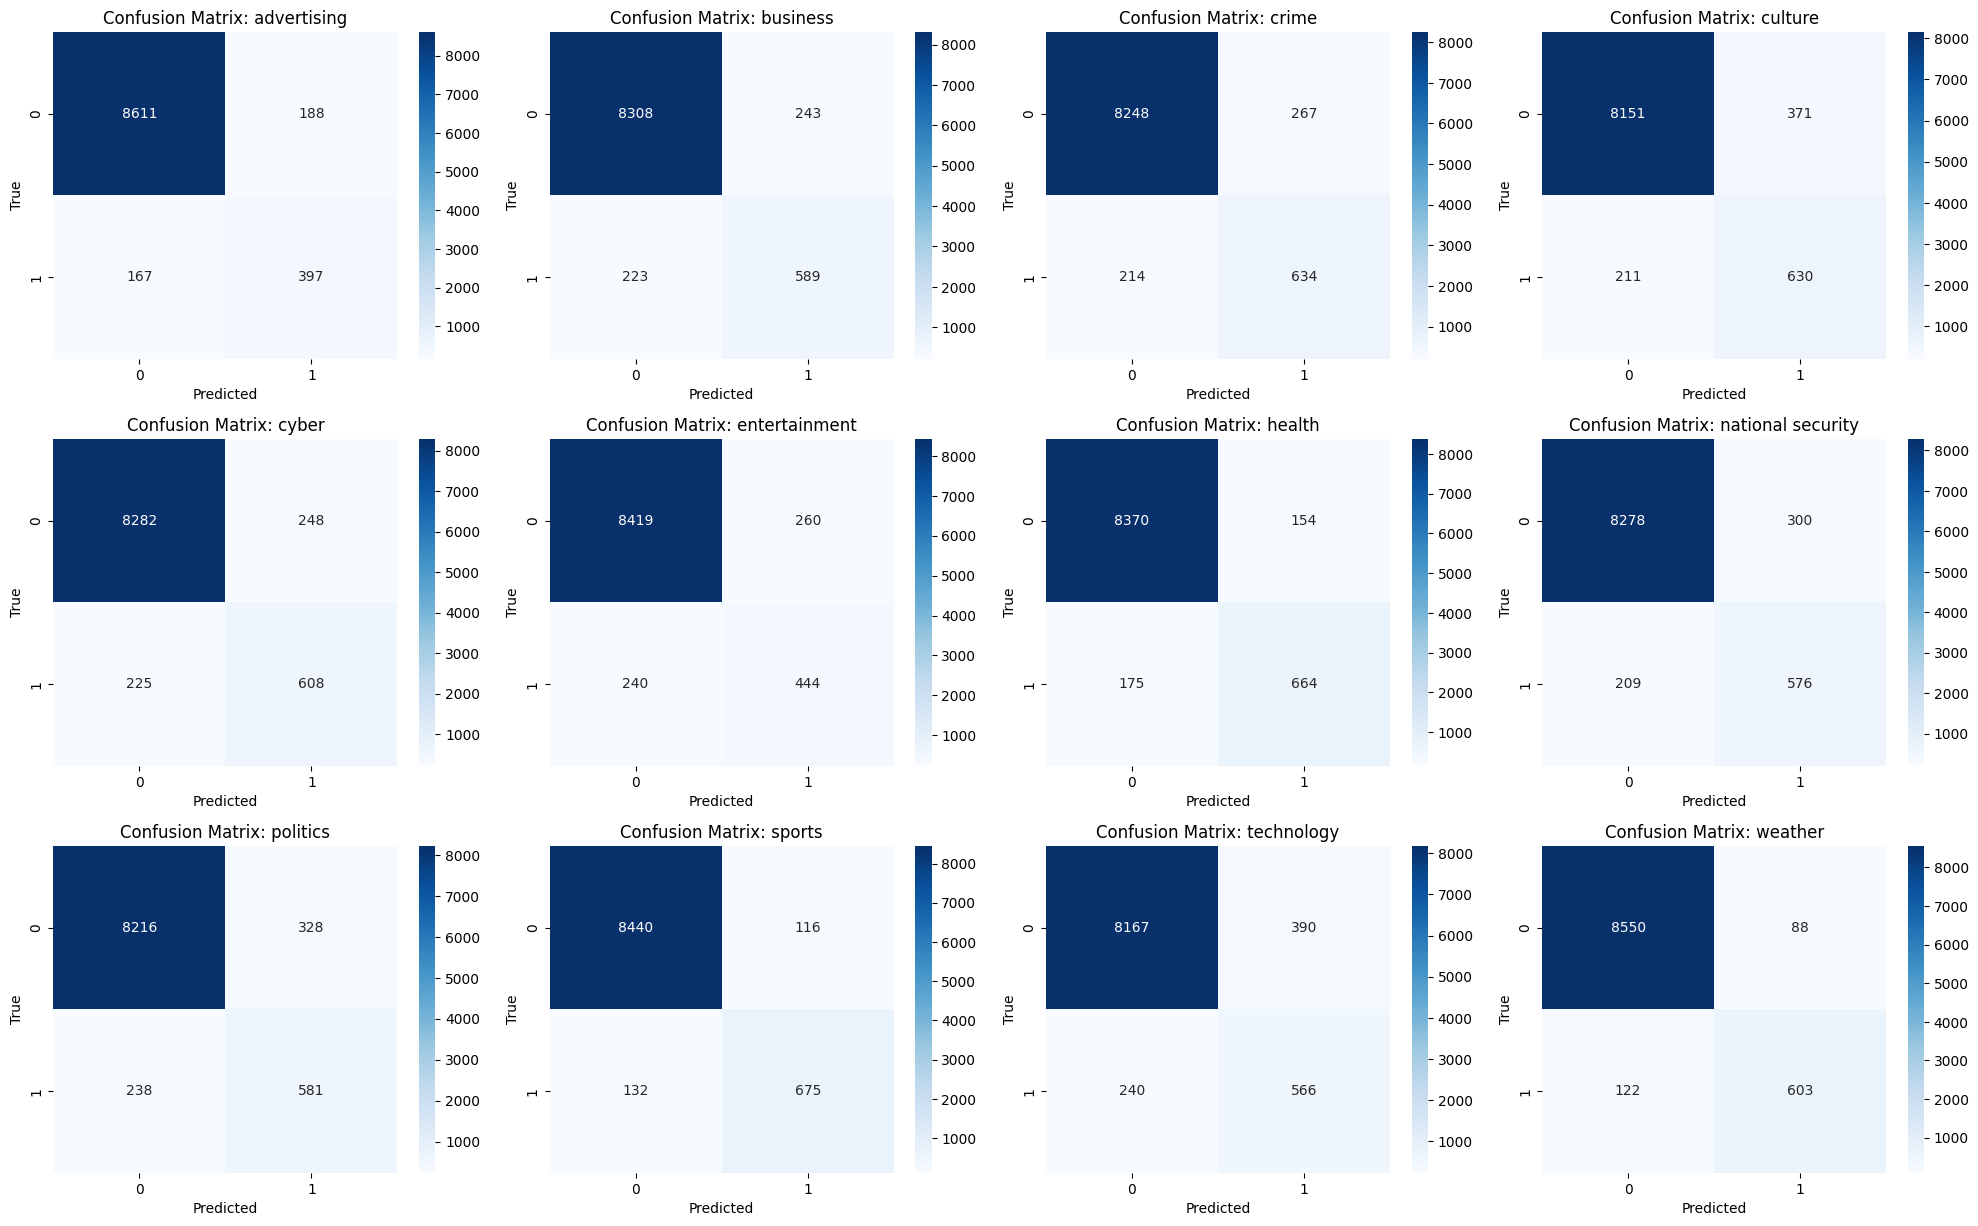

In [328]:
#GrokAI helped with the cm viz
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set up the plot
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
axes = axes.flatten()

# Compute and plot confusion matrix for each class
for i, class_name in enumerate(mlb.classes_):
    cm = confusion_matrix(y_test[:, i], y_pred_binary[:, i])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix: {class_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

# Remove empty subplots (if any)
for i in range(len(mlb.classes_), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

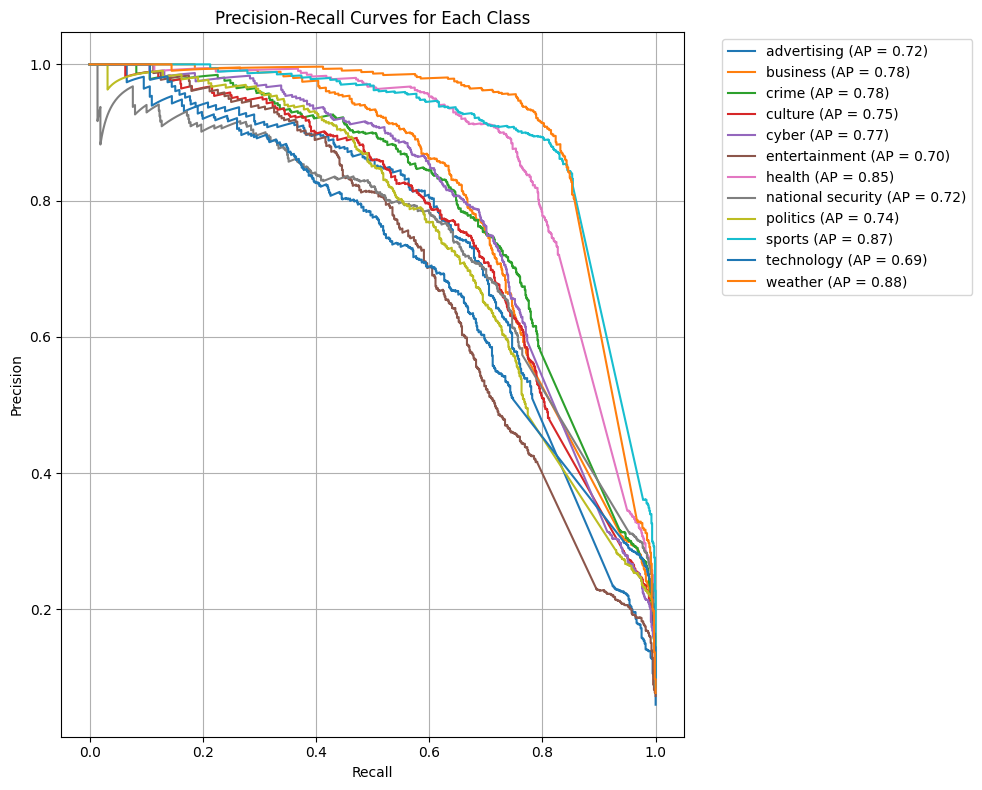

In [329]:
from sklearn.metrics import precision_recall_curve, average_precision_score
#Grok AI helped with this + the ROC curve viz
# Set up the plot
plt.figure(figsize=(10, 8))

# Compute precision-recall curve for each class
for i, class_name in enumerate(mlb.classes_):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_probs[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, label=f'{class_name} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

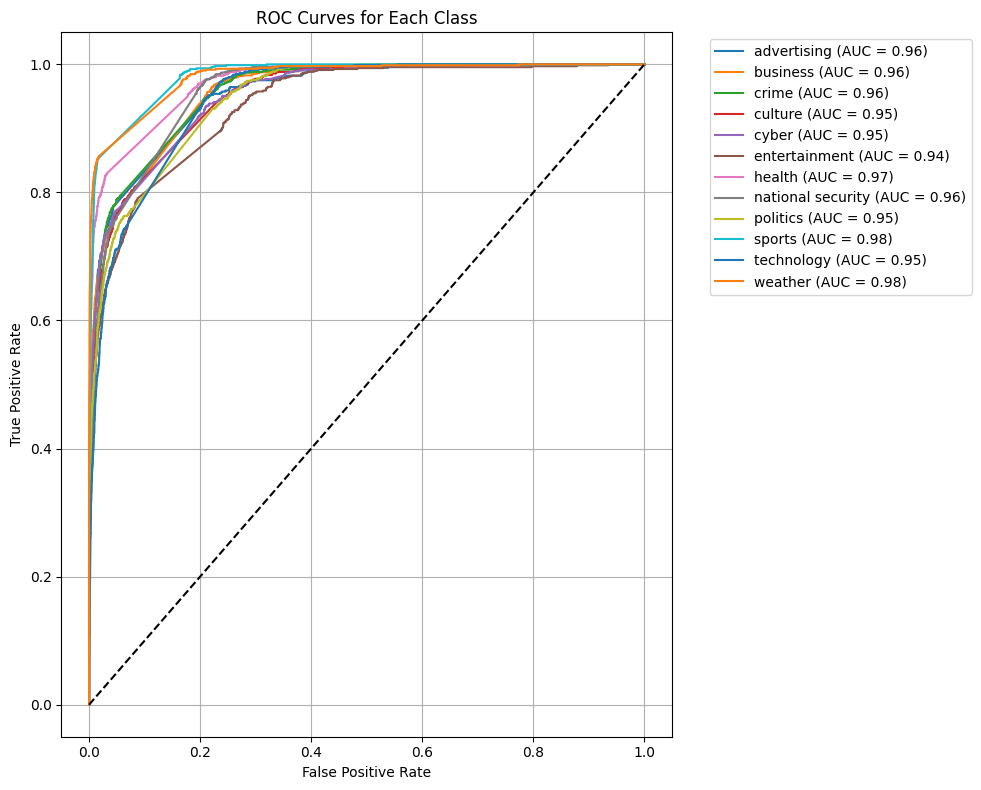

In [330]:
from sklearn.metrics import roc_curve, roc_auc_score

# Set up the plot
plt.figure(figsize=(10, 8))

# Compute ROC curve for each class
for i, class_name in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])
    roc_auc = roc_auc_score(y_test[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Lets test out how this performs across the entire df

In [331]:
#Grok helped create this function

def at_least_one_correct_accuracy(y_true, y_pred):
    """
    Compute accuracy where a sample is correct if at least one predicted positive label
    matches a true positive label.
    
    Args:
        y_true (np.array): True binary labels, shape (n_samples, n_classes)
        y_pred (np.array): Predicted binary labels, shape (n_samples, n_classes)
    
    Returns:
        float: Accuracy (proportion of samples with at least one correct positive label)
    """
    n_samples = y_true.shape[0]
    correct_samples = 0
    
    for i in range(n_samples):
        true_positives = y_true[i] == 1  # True labels that are positive
        pred_positives = y_pred[i] == 1  # Predicted labels that are positive
        
        # Check if there is at least one label where both true and pred are 1
        if np.any(true_positives & pred_positives):
            correct_samples += 1
        # Handle case where sample has no true positive labels
        elif np.sum(true_positives) == 0 and np.sum(pred_positives) == 0:
            correct_samples += 1  # Consider correct if model predicts no labels
    
    accuracy = correct_samples / n_samples
    return accuracy

# Compute the custom accuracy
custom_accuracy = at_least_one_correct_accuracy(y_test, y_pred_binary)
print(f"At-Least-One-Correct Accuracy: {custom_accuracy:.4f}")

At-Least-One-Correct Accuracy: 0.7441


In [332]:
#Append to all data. Grok AI helped here
import numpy as np

# Extract embeddings from the data DataFrame
X_all = np.stack(data['embedding'].values)

# Generate predicted probabilities for all samples
y_pred_probs_all = model.predict(X_all)

# Convert probabilities to binary predictions using a threshold
threshold = 0.1
y_pred_binary_all = (y_pred_probs_all >= threshold).astype(int)

14329/14329 [==============================] - 223s 16ms/step


In [310]:
# Convert binary predictions to lists of category names. Grok AI
predicted_categories = []
for binary_row in y_pred_binary_all:
    # Get indices where the prediction is 1
    pred_indices = np.where(binary_row == 1)[0]
    # Map indices to category names
    pred_labels = [mlb.classes_[idx] for idx in pred_indices]
    predicted_categories.append(pred_labels)

# Ensure the length matches the data DataFrame
assert len(predicted_categories) == len(data), "Prediction length does not match DataFrame length"

In [315]:
# Add the predicted categories as a new column. Grok AI
data['preds'] = predicted_categories


In [312]:
from sklearn.preprocessing import MultiLabelBinarizer
#Grok AI helped here. 
# Assuming mlb is already fitted (from your notebook)
# If not, refit it:
mlb = MultiLabelBinarizer()
mlb.fit(data['categories'])

# Convert true categories to binary matrix
y_true_all = mlb.transform(data['categories'])

# Compute the custom accuracy
custom_accuracy = at_least_one_correct_accuracy(y_true_all, y_pred_binary_all)
print(f"At-Least-One-Correct Accuracy: {custom_accuracy:.4f}")

At-Least-One-Correct Accuracy: 0.7765
